In [11]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import numpy as np
import pandas as pd
import networkx as nx
import constants

%matplotlib inline
ox.__version__

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [ ]:
nodes = gpd.read_file("data/communities_bc/nodes.shp")
edges = gpd.read_file("data/communities_bc/edges.shp")
nodes[nodes["bc"] != None]
#edges = gpd.read_file("data/communities_bc/edges.shp")

In [3]:
#initialize all entries to False
#for category in constants.CATEGORIES:
#    nodes[category] = False

In [4]:
nodes[nodes["bc_food"]==True]

,osmid,osmid_orig,x,y,street_cou,POI,edu,health,transp,food,lon,lat,bc,bc_health,bc_edu,highway,bc_food,ref,bc_transp,geometry


In [5]:
nodes = nodes.set_index("osmid")
edges = edges.set_index(['u', 'v', 'key'])

G = ox.utils_graph.graph_from_gdfs(nodes, edges)

<h1>Coverage</h1>
<p>Given a graph G = (nodes, edges) knowing that in the edges there are some POIs, modify the nodes table to have that: nodes below 15 minutes to at least a POI of a certain category have that category column set to true.</p>
<p>Example: Suppose node i is below 15 minutes to 2 schools, 4 supermarkets and nothing more, then these will be its column values</p>
<table>
  <tr>
    <th>education</th>    
    <th>bank</th>
    <th>healthcare</th>
    <th>transportation</th>    
    <th>food</th>
  </tr>
  <tr>
    <td>True</td>
    <td>False</td>
    <td>False</td>
    <td>False</td>
    <td>True</td>
  </tr>

In [6]:
#travel_speed = 5  # walking speed in km/hour

# add an edge attribute for time in minutes required to traverse each edge
#meters_per_minute = travel_speed * 1000 / 60  # km per hour to m per minute
#for _, _, _, data in G.edges(data=True, keys=True):
#    data["time"] = data["length"] / meters_per_minute

In [7]:
nodes, edges = ox.graph_to_gdfs(G)
nodes.head()

,osmid_orig,x,y,street_cou,POI,edu,health,transp,food,lon,lat,highway,bc,bc_health,bc_edu,bc_food,ref,bc_transp,geometry
osmid,,,,,,,,,,,,,,,,,,,
0,"[141540485, 254672751, 197522982, 254672878, 2...",724701.900173,5.034203e+06,0,transp,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (724701.900 5034203.206)
235,"[197523004, 345286935, 1706766370, 559475298, ...",724667.547169,5.034311e+06,0,NaN,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (724667.547 5034311.202)
233,243488899,724825.279648,5.034265e+06,5,NaN,1,1,1,1,11.873938,45.425744,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (724825.280 5034265.244)
628,"[2522360857, 243486447, 2522360875, 2522360879...",724832.620828,5.033955e+06,0,transp,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (724832.621 5033954.570)
643,243487238,724773.189779,5.034232e+06,3,NaN,1,1,1,1,11.873258,45.425462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (724773.190 5034231.991)


<h2>Plot graph with all POIs</h2>
<p>We will plot a graph with red nodes representing normal nodes and blue nodes representing POIs</p>

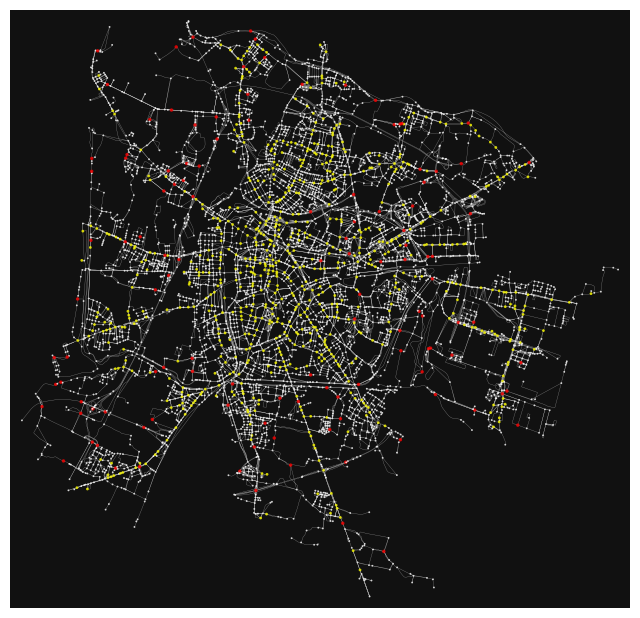

In [8]:
## color the nodes: red - normal; yellow - POIs
node_colors = {}
node_sizes = {}
for node, data in G.nodes(data=True):
    node_id = node
    poi = data.get("POI", None)
    poi_bc = data.get("bc", False)
    if poi in constants.CATEGORIES:
        node_colors[node_id] = "yellow"
        node_sizes[node_id] = 4
    elif poi_bc:
        node_colors[node_id] = "red"
        node_sizes[node_id] = 6
    else:
        node_colors[node_id] = "white"
        node_sizes[node_id] = 1.8
        
        
nc = [node_colors[node] if node in node_colors else "none" for node in G.nodes()]
ns = [node_sizes[node] if node in node_sizes else "none" for node in G.nodes()]

fig, ax = ox.plot_graph(
    G,
    node_color=nc,
    node_size=ns,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)

<h2>Plot subgraphs with close nodes for each category</h2>
<p>Plot multiple graphs (one for each category) where blue nodes are POIs, green nodes are the ones near to at least a POI, i.e. covered, red are uncovered nodes (>15 min).</p>

In [9]:
#Create a list of POIs for each category of the new nodes
poi_nodes = dict.fromkeys(constants.CATEGORIES, [])
    
for node, data in G.nodes(data=True):
    for category in constants.CATEGORIES:
        bc = data.get(f"bc_{category}", False)
        if bc:
            poi_nodes[category].append(node_id)
print(sum(len(lst) for lst in poi_nodes.values()))

736


In [10]:
#Compute a subgraph of covered nodes for each category
trip_time = 15
subgraph_nodes = {}
for category in constants.CATEGORIES:
    subgraph_nodes[category] = []
    for poi_id in poi_nodes[category]:
        subgraph = nx.ego_graph(G, poi_id, radius=trip_time, distance="time", undirected=True)
        for n in subgraph.nodes():
            subgraph_nodes[category].append(n)

for c in constants.CATEGORIES:
    print(len(subgraph_nodes[c])) #subgraph_nodes contains duplicate nodes (that's why nombers are high)



KeyboardInterrupt



In [ ]:
#Update nodes table with coverage results
for index, node in nodes.iterrows():
    for category in constants.CATEGORIES:
        if(index in subgraph_nodes[category]):
            nodes.at[index, category] = True

<h3>Print graph with covered nodes for each category</h3>

In [ ]:
def printCoveredNodes(poi_cat, print_=True):
    node_colors = []
    covered_cnt = 0
    poi_cnt = 0
    bc_cnt = 0
    uncovered_cnt = 0
    for index, node in nodes.iterrows():
        if (nodes.at[index, "POI"] == poi_cat):
            node_colors.append("yellow")  
            poi_cnt += 1
        elif (nodes.at[index, "bc"] == True):
            node_colors.append("white")  
            bc_cnt += 1
        else:
            if nodes.at[index, poi_cat] == True:
                node_colors.append("green")  
                covered_cnt += 1
            else:
                node_colors.append("red")
                uncovered_cnt += 1
    if(print_):
        print("Number of covered nodes (green): ", covered_cnt)
        print("Number of poi nodes (yellow): ", poi_cnt)
        print("Number of new nodes with BC (white): ", bc_cnt)
        fig, ax = ox.plot_graph(
            G,
            node_color=node_colors,
            node_size=4,
            node_alpha=0.8,
            edge_linewidth=0.2,
            edge_color="#999999",
        )
    return covered_cnt

In [ ]:
for c in constants.CATEGORIES:
    print("Printing graph of covered nodes from " , c)
    printCoveredNodes(c)

<h1>Analysis</h1>
<p>Now that we have obtained all covered nodes for each category we can evaluate some interesting results.</p>

In [ ]:
from IPython.display import Markdown as md

In [ ]:
s = "<h2>Covered nodes for each category</h2>"
if(len(constants.CATEGORIES) > 0):
    s +="<table>"
    s +="<tr>"
    s +="<th>Category</th>"
    s +="<th>Num. Covered nodes</th>"
    s +="<th>Percentage of coverage</th>"
    s +="</tr>"
    for c in constants.CATEGORIES:
        s +="<tr>"
        covered = printCoveredNodes(c, False)
        percentage = covered * 100 / len(nodes)
        formatted_percentage = round(percentage, 2)
        result_str = str(formatted_percentage)
        s +="<td>"+c+"</td>" 
        s +="<td>"+str(covered)+"</td>" 
        s +="<td>"+result_str+"%</td>" 
        s +="</tr>"
        #print(c, ": " , covered, " covered nodes: %.1f" %(covered*100/len(nodes)), "% of the total"
    s +="</table>"
s += """
<h2>Percentage of nodes covered by all categories</h2>
<p>The following number is a possible representation of how a city is well covered:</p>
"""
# Save nodes'id that are near all POIs
near_all_nodes = []
for index, node in nodes.iterrows():
    near_all = True
    for category in constants.CATEGORIES:
        if(index not in subgraph_nodes[category]):
            near_all = False
    if(near_all):
        near_all_nodes.append(index)
s +="<table>"
s +="<tr>"
s +="<th>Number of covered nodes</th>"
s +="<th>Total number of nodes</th>"
s +="<th>Percentage of covered nodes</th>"
s +="</tr>"
s +="<tr>"
percentage = len(near_all_nodes) * 100 / len(nodes)
formatted_percentage = round(percentage, 2)
result_str = str(formatted_percentage)
s +="<td>"+str(len(near_all_nodes))+"</td>" 
s +="<td>"+str(len(nodes))+"</td>" 
s +="<td>"+result_str+"%</td>" 
s +="</tr>"
s +="</table>"
s += """
<h2>Percentage of isolated nodes</h2>
<p>These are the nodes that are not near any POI:</p>

"""
# Save nodes'id that are not near any POI
isolated_nodes = []
for index, node in nodes.iterrows():
    isolated = True
    for category in constants.CATEGORIES:
        if(index in subgraph_nodes[category]):
            isolated = False
    if(isolated):
        isolated_nodes.append(index)
s +="<table>"
s +="<tr>"
s +="<th>Number of isolated nodes</th>"
s +="<th>Total number of nodes</th>"
s +="<th>Percentage of isolated nodes</th>"
s +="</tr>"
s +="<tr>"
percentage = len(isolated_nodes) * 100 / len(nodes)
formatted_percentage = round(percentage, 2)
result_str = str(formatted_percentage)
s +="<td>"+str(len(isolated_nodes))+"</td>" 
s +="<td>"+str(len(nodes))+"</td>" 
s +="<td>"+result_str+"%</td>" 
s +="</tr>"
s +="</table>"
md(s)

<h2>Graph plot of nodes covered by all categories and of isolated nodes</h2>

In [ ]:
node_colors = []
covered_cnt = 0
poi_cnt = 0
uncovered_cnt = 0
for index, node in nodes.iterrows():
    if (nodes.at[index, "POI"] in constants.CATEGORIES):
        node_colors.append("yellow")  
    else:
        if (index in near_all_nodes):
            node_colors.append("green")  
        elif(index in isolated_nodes):
            node_colors.append("red")
        else:
            node_colors.append("grey")
print("Graph of 15 minutes nodes:\n\t- yellow: POIs\n\t- green: Nodes near all constants.CATEGORIES\n\t- red: Isolated nodes\n\t- grey: Other nodes")
fig, ax = ox.plot_graph(
    G,
    node_color=node_colors,
    node_size=4,
    node_alpha=0.8,
    edge_linewidth=0.2,
    edge_color="#999999",
)